## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

 a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. Find the number of unique users in the dataset.

In [4]:
df.user_id.nunique() 

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the new_page and treatment don't line up.

In [6]:
df2 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df2.shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.    

a. Use the results to create a new dataset. Store your new dataframe in **df2**.

In [8]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

Based on the findings there does not appear to be a significant difference in the conversion rate of users that landed on the new page at variance with the oldpage. The control group that landed on the old page converted at a rate of 12.04% in comparison to 11.88% for the treatment group that landed on the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

                                            𝐻0:𝑝𝑛𝑒𝑤−𝑝𝑜𝑙𝑑≤0
                                            𝐻1:𝑝𝑛𝑒𝑤−𝑝𝑜𝑙𝑑>0          

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(n_new,p_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted/n_new - old_page_converted/n_old

-0.0006074307334281576

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    4.,    58.,   364.,  1470.,  2998.,  3044.,  1613.,   409.,
           36.,     4.]),
 array([ -5.15720958e-03,  -4.13236394e-03,  -3.10751830e-03,
         -2.08267266e-03,  -1.05782701e-03,  -3.29813715e-05,
          9.91864270e-04,   2.01670991e-03,   3.04155555e-03,
          4.06640120e-03,   5.09124684e-03]),
 <a list of 10 Patch objects>)

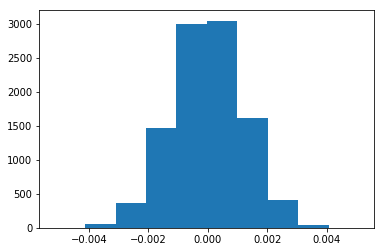

In [26]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(act_diff)
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

-0.00157823898536


0.90129999999999999

The result of part j. indicates the probability of getting our statistic or a more extreme value if the null is true, designated as the p-value.

The large p-value demonstrates weak evidence against the null hypothesis. Therefore, we fail to reject the null hypothesis which suggest the new page conversion rate is higher than the old rate.

The p-value calculated is 0.9. This is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, we would fail to reject the null and conclude that there is not sufficient evidence to say that that there is a difference between the two values.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score results are less the the 95% critical value. Accordingly, we fail to reject the null hypotheis comparable with parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-23 19:58 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value denotes the ab_page as 0.19 remaining above 𝛼 alpha level of 0.05 diffentiating as it is a two tailed test. Subsequently, we fail to reject the null hypotheis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding factors to ones regression model may bring more accuracy in our resulting hypothesis and in this case influence conversions. The disadvantage is that we may not know the direction that adding these additional factors will influence our results. Since additional factors yields to changes when adding factors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('CA', axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,0


In [37]:
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK', 'US']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-23 19:58 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

We find that the p-values for the countries are well above a 0.05 𝛼 level and do not show a substantial difference in the conversion rates for control group and treatment group. Accordingly, we fail to reject the Null Hypothesis

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
log_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-23 19:58 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

## Conclusions

The data analysis results indicate that there is not a significant difference in conversion rates between the new and old pages including from one country to another. Subsequently, we do not reject the null hypothesis. 